<div align='center'>
    <img src='https://neurohive.io/wp-content/uploads/2019/05/Screenshot-from-2019-05-29-21-23-47.png')', width='100%'>
</div>
Decisions of the "Digit Recognizer" competition https://www.kaggle.com/competitions/digit-recognizer/overview/

## 1. Loading libraries and data.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import torch
from torch import tensor, nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torchvision import models
from sklearn.model_selection import train_test_split
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv') # Loading training data
test = pd.read_csv('test.csv') # Loading test data
sample_sub = pd.read_csv('sample_submission.csv') # Loading the answer sheet
train.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
train.tail(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
41990,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41991,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41992,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41993,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41994,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41999,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2. EDA (exploratory data analysis).

In [4]:
print(f"The training data contains {train.shape[0]} records and {train.shape[1]} traits")

The training data contains 42000 records and 785 traits


In [5]:
print(f"Test data contains {test.shape[0]} records and {test.shape[1]} traits")

Test data contains 28000 records and 784 traits


In [6]:
print(f"The amount of missing data: {train.isnull().sum().sum()}")

The amount of missing data: 0


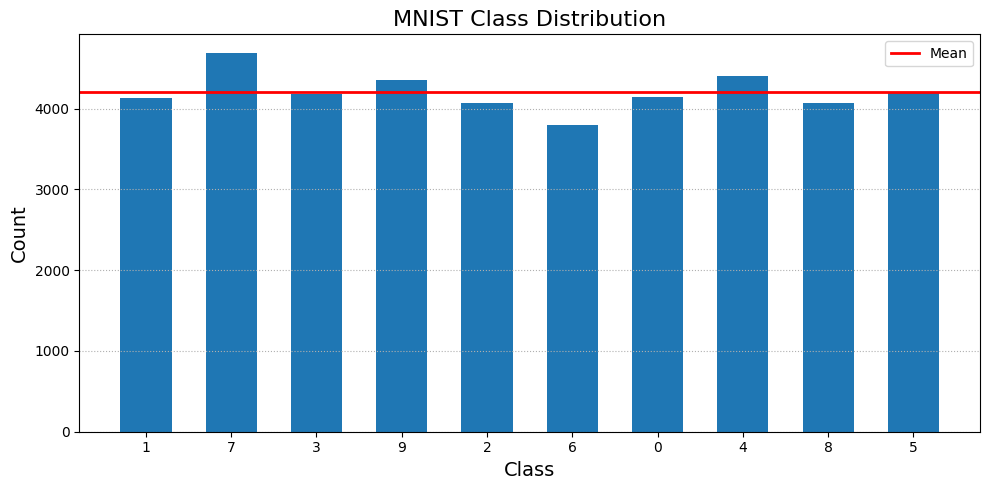

In [7]:
labels = train.label.value_counts().index # Get the class names
counts = train.label.value_counts() # Get the number of rows by class

plt.figure(figsize=(10, 5))
plt.bar(labels, counts, width=0.6)
plt.xticks(np.arange(len(labels)), labels)
plt.xlabel('Class', fontsize=14) # Add text to the X-axis
plt.ylabel('Count', fontsize=14) # Add text to the Y axis
plt.title('MNIST Class Distribution', fontsize=16) # Add a header about class distribution

# We add a line to show the uniformity of the distribution of features
plt.axhline(counts.mean(), color='red', linewidth=2, label='Mean')

plt.legend()
plt.grid(axis='y', linestyle='dotted')

plt.tight_layout()
plt.show()

##### Conclusions on the second block:

    1. missing data are missing.
    2. The features for classification are the same for training and test data.
    3. All classes are distributed +- evenly.

## 3. Data preprocessing.

### 3.1. Preprocessing of training and test data.

In [8]:
# Change the color depth from 0 to 1
X = train.drop('label', axis=1) # Keeping the image clean
X = np.array(X)
X = X.astype('float32')
X = X / 255.0

# Convert an image from one channel to RGB
X = cv2.cvtColor(X, cv2.COLOR_GRAY2RGB)
X = X.reshape(-1, 28, 28, 3)

# Resize to 30x30 pixels
newX = []
for image in X:
    image = cv2.resize(image, dsize=(30, 30), interpolation=cv2.INTER_AREA)
    newX.append(image)
newX = np.array(newX)
newX = newX.astype('float32')
newX = newX / 255.0
X = newX.reshape(-1, 3, 30, 30)

# Get a list of the target metric
y = train.label 

In [9]:
# Change the color depth from 0 to 1
test = np.array(test)
test = test.astype('float32')
test = test / 255.0

# Convert an image from one channel to RGB
test = cv2.cvtColor(test, cv2.COLOR_GRAY2RGB)
test = test.reshape(-1, 28, 28, 3)

# Resize to 30x30 pixels
newX = []
for image in test:
    image = cv2.resize(image, dsize=(30, 30), interpolation=cv2.INTER_AREA)
    newX.append(image)
newX = np.array(newX)
newX = newX.astype('float32')
newX = newX / 255.0
test = newX.reshape(-1, 3, 30, 30)

### 3.2. Form a training and validation sample. Create datasets for the neural network.

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
X_train_t =  torch.from_numpy(X_train).float()
y_train_t =  torch.from_numpy(y_train.values)
X_val_t =  torch.from_numpy(X_val).float()
y_val_t =  torch.from_numpy(y_val.values)

In [11]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=64)
val_dataloader = DataLoader(val_dataset, batch_size=64)

## 4. Creating a neural network and training it.

### 4.1. Selecting a device for model training.

In [12]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

### 4.2. Declaring the structure of a neural network.

In [13]:
model = models.densenet121() # Loading structure and weights
model.classifier = torch.nn.Linear(1024, 10) # Replacing the classification layer
model.to(device) # Downloading the model to the device

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
loaders = {"train": train_dataloader, "valid": val_dataloader}

### 4.3. Процесс обучения нейронной сети

In [15]:
max_epochs = 500
best_model = model # Best model
last_loss = np.Inf # The last mistake
epoch_erly_stopping = 0
flag = False 
col_not_best = 0 # Number of epochs unchanged
accyracy_best = 0 # Better accuracy
accuracy_history = {"train": [], "valid": []} # History of accuracy on samples
loss_history = {"train": [], "valid": []} # History of error on the samples
train_losses = [] 
valid_losses = []
start_time = datetime.now()
for epoch in range(max_epochs+1):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            # Transfer data to the device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                model.train()
                optimizer.zero_grad() # Zeroing out the error gradients
                outp = model(x_batch) # Getting answers from the model
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1) # Softmax, we get a class
            correct = (preds == y_batch).sum() # Number of correct answers
            all = preds.size(0) # Number of all responses
            epoch_correct += correct.item() # Number of photos correctly recognized
            epoch_all += all #  Total number of photos
            loss = criterion(outp, y_batch) # Calculating the graditi
            if k == "train":
                train_losses.append(loss.item())
                loss.backward()
                optimizer.step()
            else:
                valid_losses.append(loss.item())

        if k == "valid":
            train_loss = np.average(train_losses)
            valid_loss = np.average(valid_losses)
            loss_history["train"].append(train_loss)
            loss_history["valid"].append(valid_loss)
            print(f"[{epoch:>3}/{max_epochs:>3}] loss train: {train_loss:.5f} | loss valid: {valid_loss:.5f}")

            # If the error is dropped, we save it as the best model
            if round(last_loss, 5) > round(valid_loss, 5):
                col_not_best = 0
                best_model = model
                epoch_erly_stopping = epoch
                torch.save(best_model, "checkpoint.pt")
                print(f"Validation loss decreased ({last_loss:.5f} --> {valid_loss:.5f}).  Saving model ...")
                last_loss = valid_loss
            else:
                # Проверяем на отсутсвие роста 20 эпох
                if col_not_best + 1 >= 20:
                    print("Early stopping!")
                    accuracy_history[k].append(epoch_correct/epoch_all)
                    flag = True
                    break
                else:
                    col_not_best += 1
                    print(f"EarlyStopping counter: {col_not_best} out of 20")                  
        accuracy_history[k].append(epoch_correct/epoch_all)
    if flag:
        break
torch.save(best_model, "model121.pth")
print(f'Program execution time: {datetime.now() - start_time}')

[  0/500] loss train: 0.29343 | loss valid: 0.17408
Validation loss decreased (inf --> 0.17408).  Saving model ...
[  1/500] loss train: 0.20834 | loss valid: 0.13766
Validation loss decreased (0.17408 --> 0.13766).  Saving model ...
[  2/500] loss train: 0.16635 | loss valid: 0.12904
Validation loss decreased (0.13766 --> 0.12904).  Saving model ...
[  3/500] loss train: 0.14112 | loss valid: 0.11949
Validation loss decreased (0.12904 --> 0.11949).  Saving model ...
[  4/500] loss train: 0.12337 | loss valid: 0.11604
Validation loss decreased (0.11949 --> 0.11604).  Saving model ...
[  5/500] loss train: 0.10962 | loss valid: 0.11687
EarlyStopping counter: 1 out of 20
[  6/500] loss train: 0.09964 | loss valid: 0.11321
Validation loss decreased (0.11604 --> 0.11321).  Saving model ...
[  7/500] loss train: 0.09189 | loss valid: 0.11128
Validation loss decreased (0.11321 --> 0.11128).  Saving model ...
[  8/500] loss train: 0.08542 | loss valid: 0.10798
Validation loss decreased (0.111

### 4.4. Analyzing accuracy from the training epoch of a neural network.

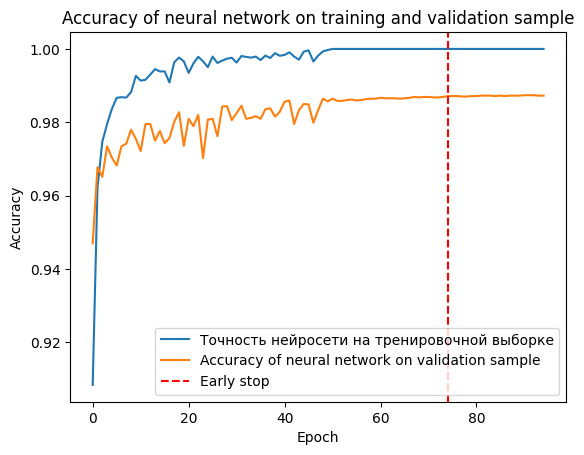

In [16]:
plt.plot(accuracy_history['train'], label='Точность нейросети на тренировочной выборке')
plt.plot(accuracy_history['valid'], label='Accuracy of neural network on validation sample')
plt.title('Accuracy of neural network on training and validation sample')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.axvline(epoch_erly_stopping, color='red', linestyle='--', label='Early stop')
plt.legend()
plt.show()

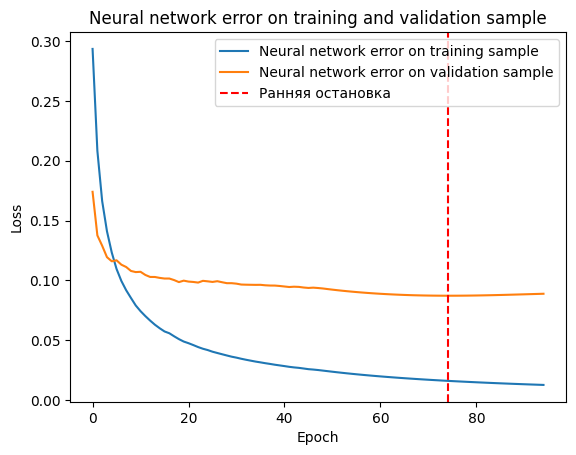

In [17]:
plt.plot(loss_history["train"], label='Neural network error on training sample')
plt.plot(loss_history["valid"], label='Neural network error on validation sample')
plt.title('Neural network error on training and validation sample')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.axvline(epoch_erly_stopping, color='red', linestyle='--', label='Ранняя остановка')
plt.legend()
plt.show()

## 5. Prediction of a neural network on a test sample.

In [18]:
test_t = torch.from_numpy(test).to(device)

In [19]:
with torch.no_grad():
    best_model.eval() # Putting the model into the prediction state
    outp = model(test_t) # Getting answers for 10 classes
preds = outp.argmax(-1) # We leave the class with the maximum value

In [20]:
preds = preds.detach().cpu().numpy() # Check if everything is correct in the outputpreds

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

In [21]:
output = pd.DataFrame({'ImageId':sample_sub.ImageId, 'Label':preds})
output.to_csv('submission.csv', index=False)

As a result, on the test data, the neural network showed an accuracy of 98.489%, which is an excellent result.